In [116]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, train_test_split

### 1. Loading the dataset

In [118]:
df = pd.read_excel("premiums_young.xlsx")
df.head()

,Age,Gender,Region,Marital_status,Number Of Dependants,BMI_Category,Smoking_Status,Employment_Status,Income_Level,Income_Lakhs,Medical History,Insurance_Plan,Annual_Premium_Amount
0,18,Male,Northeast,Unmarried,0,Overweight,Regular,Self-Employed,> 40L,99,High blood pressure,Silver,13365
1,22,Female,Northwest,Unmarried,0,Underweight,No Smoking,Freelancer,<10L,3,No Disease,Silver,11050
2,21,Female,Southeast,Unmarried,0,Normal,Regular,Salaried,> 40L,97,No Disease,Silver,11857
3,25,Male,Southeast,Unmarried,0,Normal,No Smoking,Freelancer,10L - 25L,15,No Disease,Bronze,5684
4,20,Male,Southeast,Unmarried,2,Overweight,No Smoking,Freelancer,10L - 25L,14,No Disease,Bronze,5712


In [119]:
df.shape

(20096, 13)

In [120]:
df.columns

Index(['Age', 'Gender', 'Region', 'Marital_status', 'Number Of Dependants',
       'BMI_Category', 'Smoking_Status', 'Employment_Status', 'Income_Level',
       'Income_Lakhs', 'Medical History', 'Insurance_Plan',
       'Annual_Premium_Amount'],
      dtype='object')

In [121]:
df.columns = df.columns.str.replace(' ', '_').str.lower() ## snake case convention and removing spaces
df.head()

,age,gender,region,marital_status,number_of_dependants,bmi_category,smoking_status,employment_status,income_level,income_lakhs,medical_history,insurance_plan,annual_premium_amount
0,18,Male,Northeast,Unmarried,0,Overweight,Regular,Self-Employed,> 40L,99,High blood pressure,Silver,13365
1,22,Female,Northwest,Unmarried,0,Underweight,No Smoking,Freelancer,<10L,3,No Disease,Silver,11050
2,21,Female,Southeast,Unmarried,0,Normal,Regular,Salaried,> 40L,97,No Disease,Silver,11857
3,25,Male,Southeast,Unmarried,0,Normal,No Smoking,Freelancer,10L - 25L,15,No Disease,Bronze,5684
4,20,Male,Southeast,Unmarried,2,Overweight,No Smoking,Freelancer,10L - 25L,14,No Disease,Bronze,5712


### 2. EDA & data cleaning

#### i. Handling na values

In [124]:
df.isna().sum()

age                      0
gender                   0
region                   0
marital_status           0
number_of_dependants     0
bmi_category             0
smoking_status           2
employment_status        1
income_level             4
income_lakhs             0
medical_history          0
insurance_plan           0
annual_premium_amount    0
dtype: int64

In [125]:
df.dropna(inplace = True) ## very few na as no of rows = 50k. we can just drop them.
df.isna().sum()

age                      0
gender                   0
region                   0
marital_status           0
number_of_dependants     0
bmi_category             0
smoking_status           0
employment_status        0
income_level             0
income_lakhs             0
medical_history          0
insurance_plan           0
annual_premium_amount    0
dtype: int64

#### ii. Handling duplicates

In [127]:
df.duplicated().sum() ##no duplicates

np.int64(0)

In [128]:
df.drop_duplicates(inplace=True) ## we can till keep the code because if tomorrow the file is updated and it has duplicaytes then we'll have handling code.
df.duplicated().sum()

np.int64(0)

In [129]:
df.describe()

,age,number_of_dependants,income_lakhs,annual_premium_amount
count,20090.000000,20090.000000,20090.000000,20090.000000
mean,21.494375,0.718019,22.510851,8142.096267
std,2.294052,0.940713,23.420493,2749.906347
min,18.000000,-3.000000,1.000000,3501.000000
25%,19.000000,0.000000,6.000000,6022.250000
50%,22.000000,0.000000,16.000000,7939.000000
75%,23.000000,1.000000,31.000000,9561.000000
max,25.000000,3.000000,790.000000,18186.000000


In [130]:
## max age = 356.000000, min number_of_dependants = -3, max income_lakhs = 930 (9.3 cr) | These are or can be outliers.  

#### iii. Data Cleaning: number_of_dependants

In [132]:
df[df.number_of_dependants<0].shape ## 73 values have no of dependents as negative

(22, 13)

In [133]:
df['number_of_dependants'][df.number_of_dependants < 0].unique() ## 72 rows have these values. Maybe +ve values converted to negative by mistake.

array([-3, -1])

In [134]:
df['number_of_dependants'] = abs(df['number_of_dependants'])

In [135]:
df.number_of_dependants.describe()  # now looking good

count    20090.000000
mean         0.722598
std          0.937200
min          0.000000
25%          0.000000
50%          0.000000
75%          1.000000
max          3.000000
Name: number_of_dependants, dtype: float64

#### iii. Data Cleaning: visualizing outliers

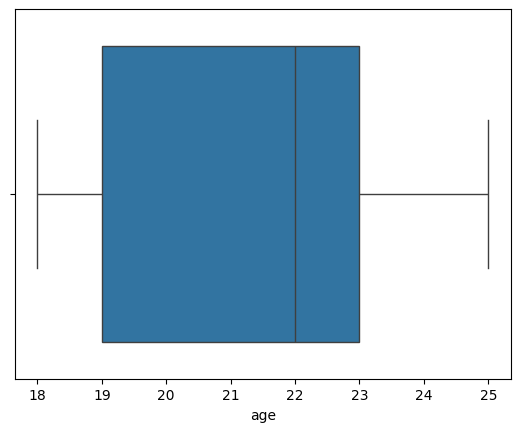

In [137]:
sns.boxplot(x = df['age'])
plt.show()

## Numeric Columns

### Univariate Analysis: Numeric Columns

In [140]:
## for all numeric columns

In [141]:
numeric_columns = df.select_dtypes(['float64','int64']).columns
numeric_columns

Index(['age', 'number_of_dependants', 'income_lakhs', 'annual_premium_amount'], dtype='object')

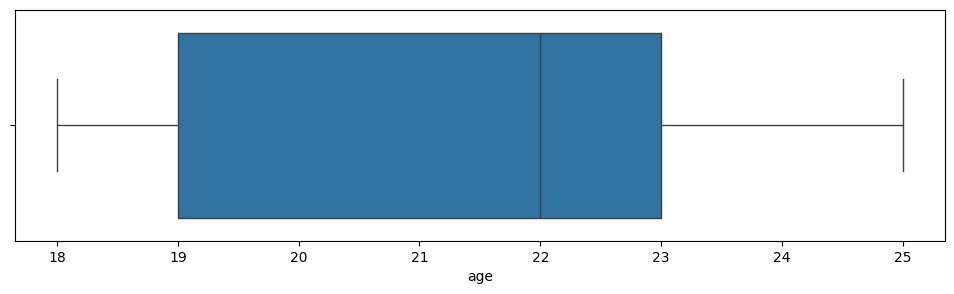

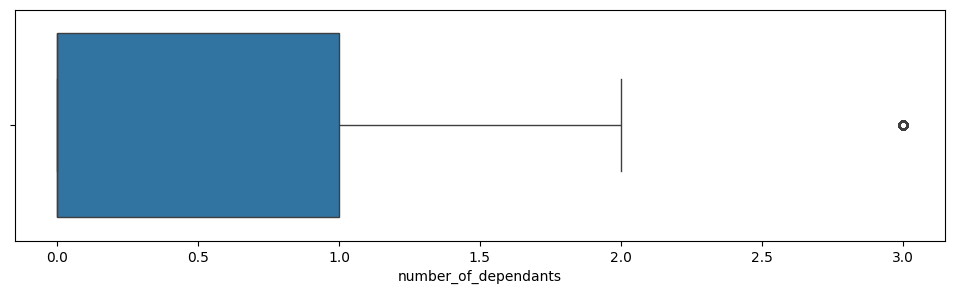

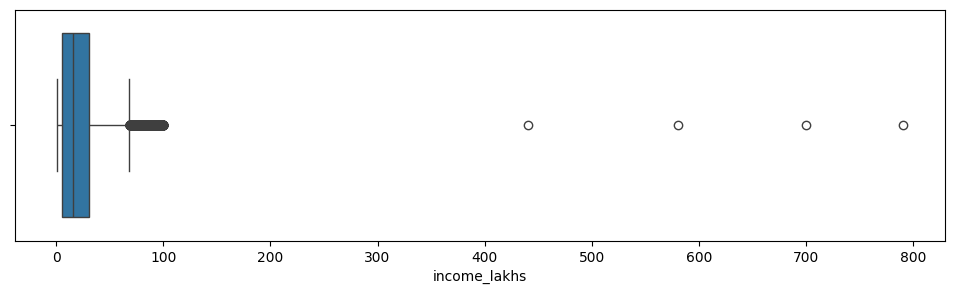

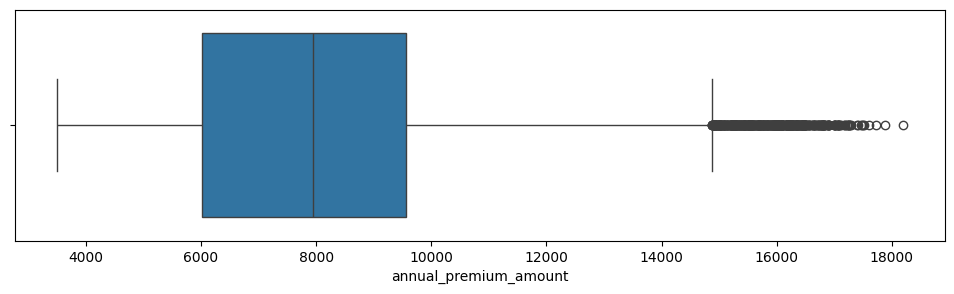

In [142]:
for col in numeric_columns:
    plt.figure(figsize=(12, 3)) 
    sns.boxplot(x=df[col])
    plt.show()

### iv. Outlier Treatment: Age Column

In [144]:
df['age'][df.age > 100].unique() 

array([], dtype=int64)

In [145]:
df1 = df[df.age<=100].copy() ## row filtering and then copying into a new df just for safety
df1.describe()  ## outliers gone from age column.

,age,number_of_dependants,income_lakhs,annual_premium_amount
count,20090.000000,20090.000000,20090.000000,20090.000000
mean,21.494375,0.722598,22.510851,8142.096267
std,2.294052,0.937200,23.420493,2749.906347
min,18.000000,0.000000,1.000000,3501.000000
25%,19.000000,0.000000,6.000000,6022.250000
50%,22.000000,0.000000,16.000000,7939.000000
75%,23.000000,1.000000,31.000000,9561.000000
max,25.000000,3.000000,790.000000,18186.000000


### iv. Outlier Treatment: Income Column

<Axes: xlabel='income_lakhs', ylabel='Count'>

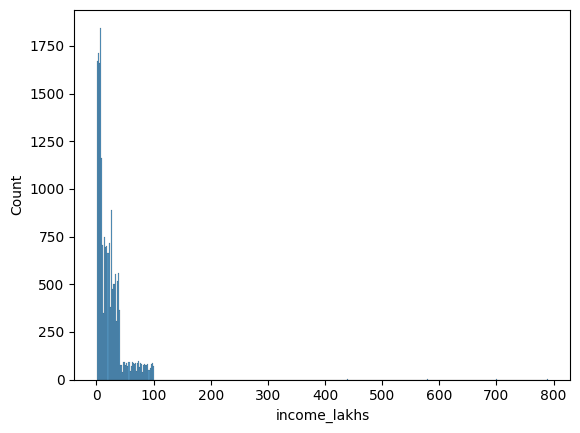

In [147]:
sns.histplot(df1.income_lakhs)

In [148]:
df.income_lakhs.quantile([0.25, 0.75])

0.25     6.0
0.75    31.0
Name: income_lakhs, dtype: float64

In [149]:
def get_iqr_bounds(col):
    Q1, Q3 = col.quantile([0.25, 0.75])
    IQR = Q3-Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return lower_bound, upper_bound

lower, upper = get_iqr_bounds(df1['income_lakhs'])
lower, upper

(-31.5, 68.5)

In [150]:
## we don't have to worry about the lower bound as anywats our minimun income is 1 lakh which is okay.

In [151]:
df[df.income_lakhs>upper].shape

(1295, 13)

In [152]:
quantile_threshold = df1.income_lakhs.quantile(0.999)
quantile_threshold

np.float64(100.0)

In [153]:
df2 = df1[df1.income_lakhs<=quantile_threshold].copy()
df2.describe()

,age,number_of_dependants,income_lakhs,annual_premium_amount
count,20086.000000,20086.000000,20086.000000,20086.000000
mean,21.494474,0.722742,22.390371,8141.799263
std,2.294248,0.937238,21.732062,2749.912486
min,18.000000,0.000000,1.000000,3501.000000
25%,19.000000,0.000000,6.000000,6022.000000
50%,22.000000,0.000000,16.000000,7939.000000
75%,23.000000,1.000000,31.000000,9561.000000
max,25.000000,3.000000,100.000000,18186.000000


In [154]:
## income 1->100 lakhs ->reasonable range

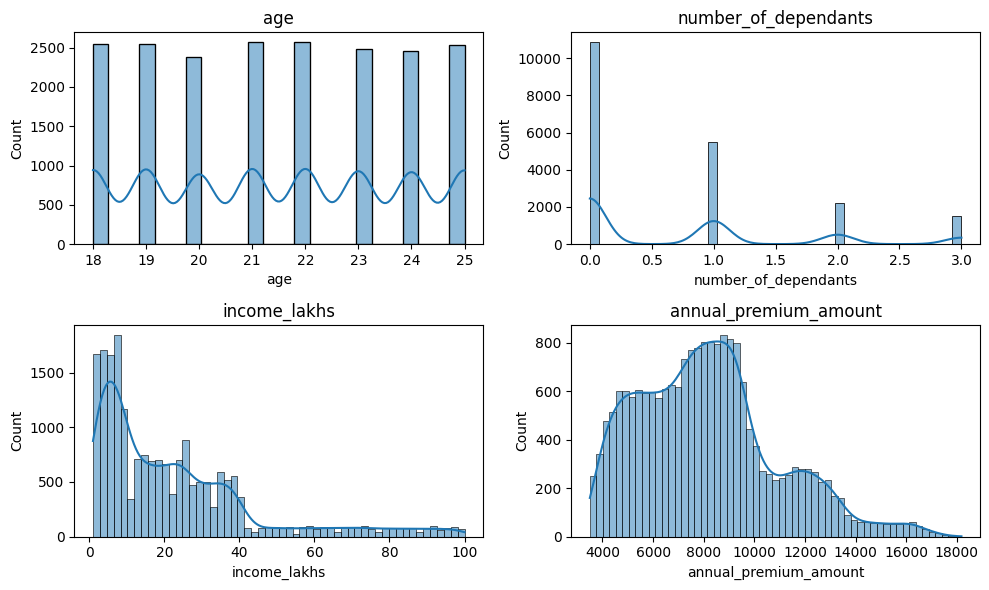

In [155]:
## visualizing the distribution of numeric datasets

fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(10, 6))

for i, column in enumerate(numeric_columns):
    ax = axs[i//2, i%2]  # Determines the position of the subplot in the grid
    sns.histplot(df2[column], kde=True, ax=ax)
    ax.set_title(column)

plt.tight_layout()
plt.show()

In [156]:
## most income datasets are right skewed

<Axes: xlabel='income_lakhs', ylabel='Count'>

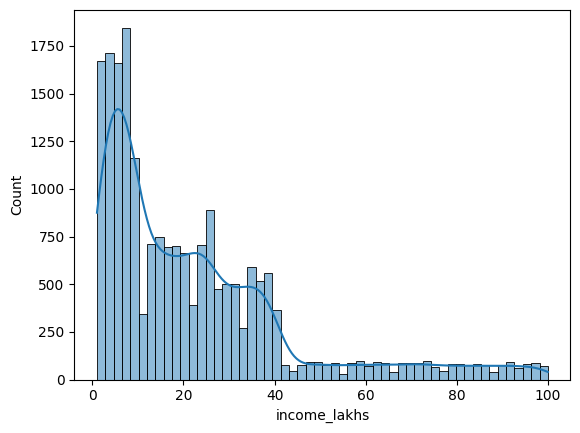

In [157]:
 sns.histplot(df2.income_lakhs, kde=True)

### Bivariate Analysis: Numeric Columns

<Axes: xlabel='age', ylabel='annual_premium_amount'>

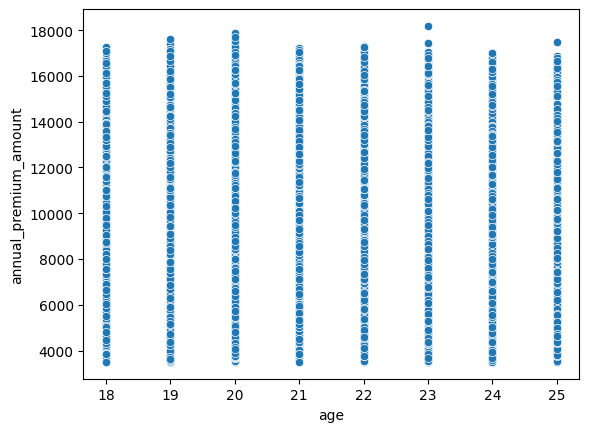

In [159]:
## scatterplot -> annual_premium_amount vs age

sns.scatterplot(df2, x = 'age', y = 'annual_premium_amount')

In [160]:
## we can se clusters here after observing carefully. 
## Also another observation-> as age increases, premium also increases. COMMON SENSE

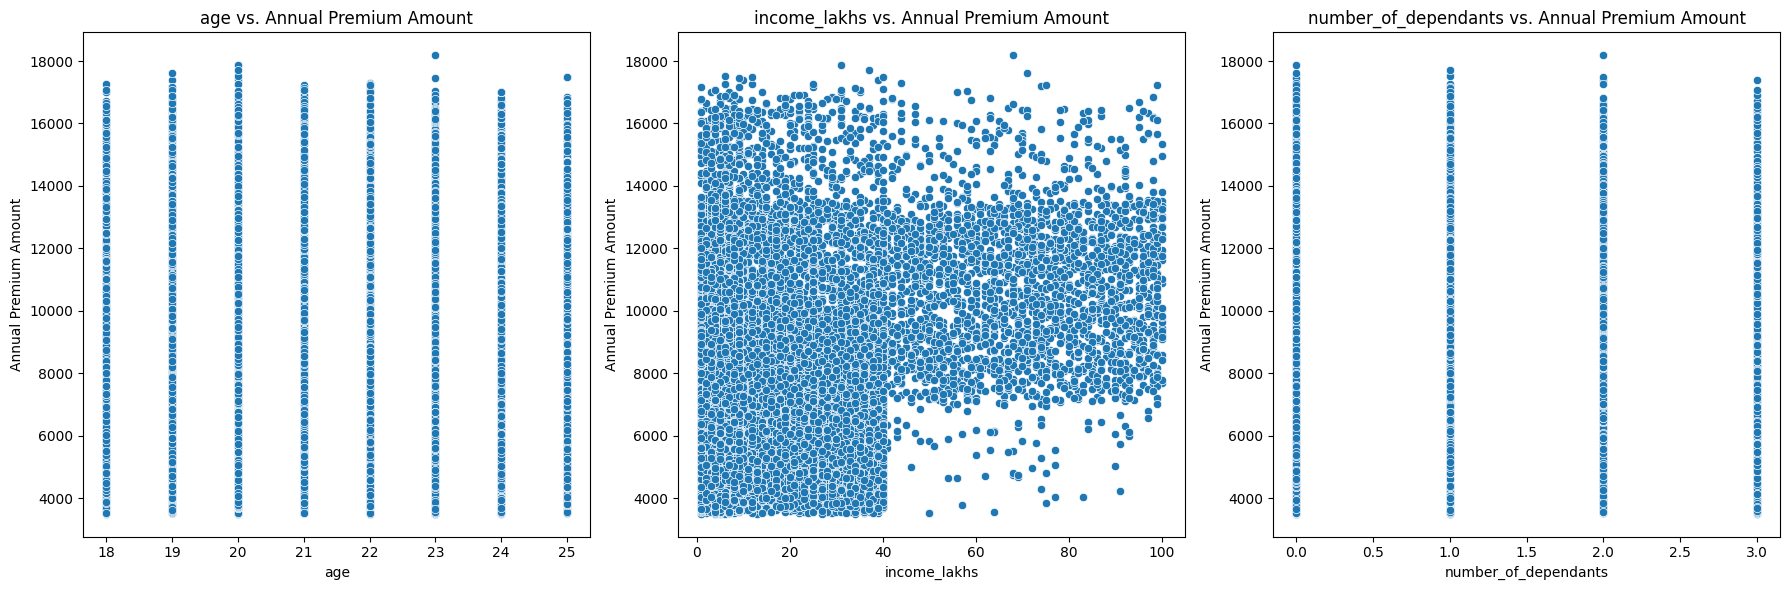

In [161]:
numeric_features = ['age', 'income_lakhs', 'number_of_dependants']

fig, axes = plt.subplots(1, len(numeric_features), figsize=(18, 6))  

for ax, column in zip(axes, numeric_features):
    sns.scatterplot(x=df2[column], y=df2['annual_premium_amount'], ax=ax)
    ax.set_title(f'{column} vs. Annual Premium Amount')
    ax.set_xlabel(column)
    ax.set_ylabel('Annual Premium Amount')

plt.tight_layout()  # Adjust layout
plt.show()

In [162]:
## not much correlation between income, premium and no of dependets, premium

##  Categorical Columns

In [164]:
categorical_cols = ['gender', 'region', 'marital_status', 'bmi_category', 'smoking_status', 'employment_status', 'income_level', 'medical_history', 'insurance_plan']
for col in categorical_cols:
    print(col, ":", df2[col].unique())

gender : ['Male' 'Female']
region : ['Northeast' 'Northwest' 'Southeast' 'Southwest']
marital_status : ['Unmarried' 'Married']
bmi_category : ['Overweight' 'Underweight' 'Normal' 'Obesity']
smoking_status : ['Regular' 'No Smoking' 'Occasional' 'Smoking=0' 'Does Not Smoke'
 'Not Smoking']
employment_status : ['Self-Employed' 'Freelancer' 'Salaried']
income_level : ['> 40L' '<10L' '10L - 25L' '25L - 40L']
medical_history : ['High blood pressure' 'No Disease' 'Diabetes & High blood pressure'
 'Diabetes & Heart disease' 'Diabetes' 'Diabetes & Thyroid'
 'Heart disease' 'Thyroid' 'High blood pressure & Heart disease']
insurance_plan : ['Silver' 'Bronze' 'Gold']


In [165]:
##smoking_status : ['No Smoking' 'Regular' 'Occasional' 'Smoking=0' 'Does Not Smoke' 'Not Smoking'] -> problems

df2['smoking_status'].replace({
    'Not Smoking': 'No Smoking',
    'Does Not Smoke': 'No Smoking',
    'Smoking=0': 'No Smoking'
}, inplace=True)

df2['smoking_status'].unique()

C:\Users\Asus\AppData\Local\Temp\ipykernel_10836\98815810.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df2['smoking_status'].replace({


array(['Regular', 'No Smoking', 'Occasional'], dtype=object)

In [166]:
### Univariate Analysis: Categorical columns

In [167]:
pct_count = df2['gender'].value_counts(normalize = True)
pct_count

gender
Male      0.550383
Female    0.449617
Name: proportion, dtype: float64

<Axes: xlabel='gender'>

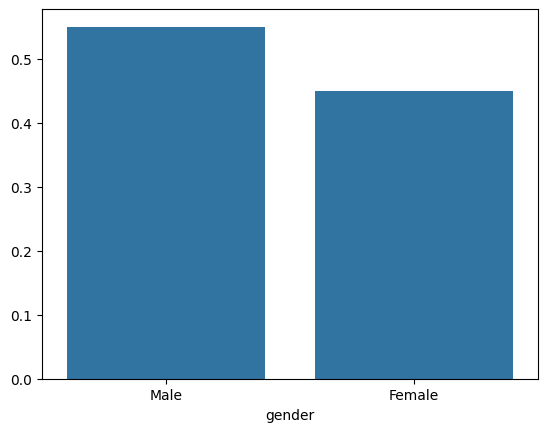

In [168]:
sns.barplot(x=pct_count.index, y=pct_count.values)

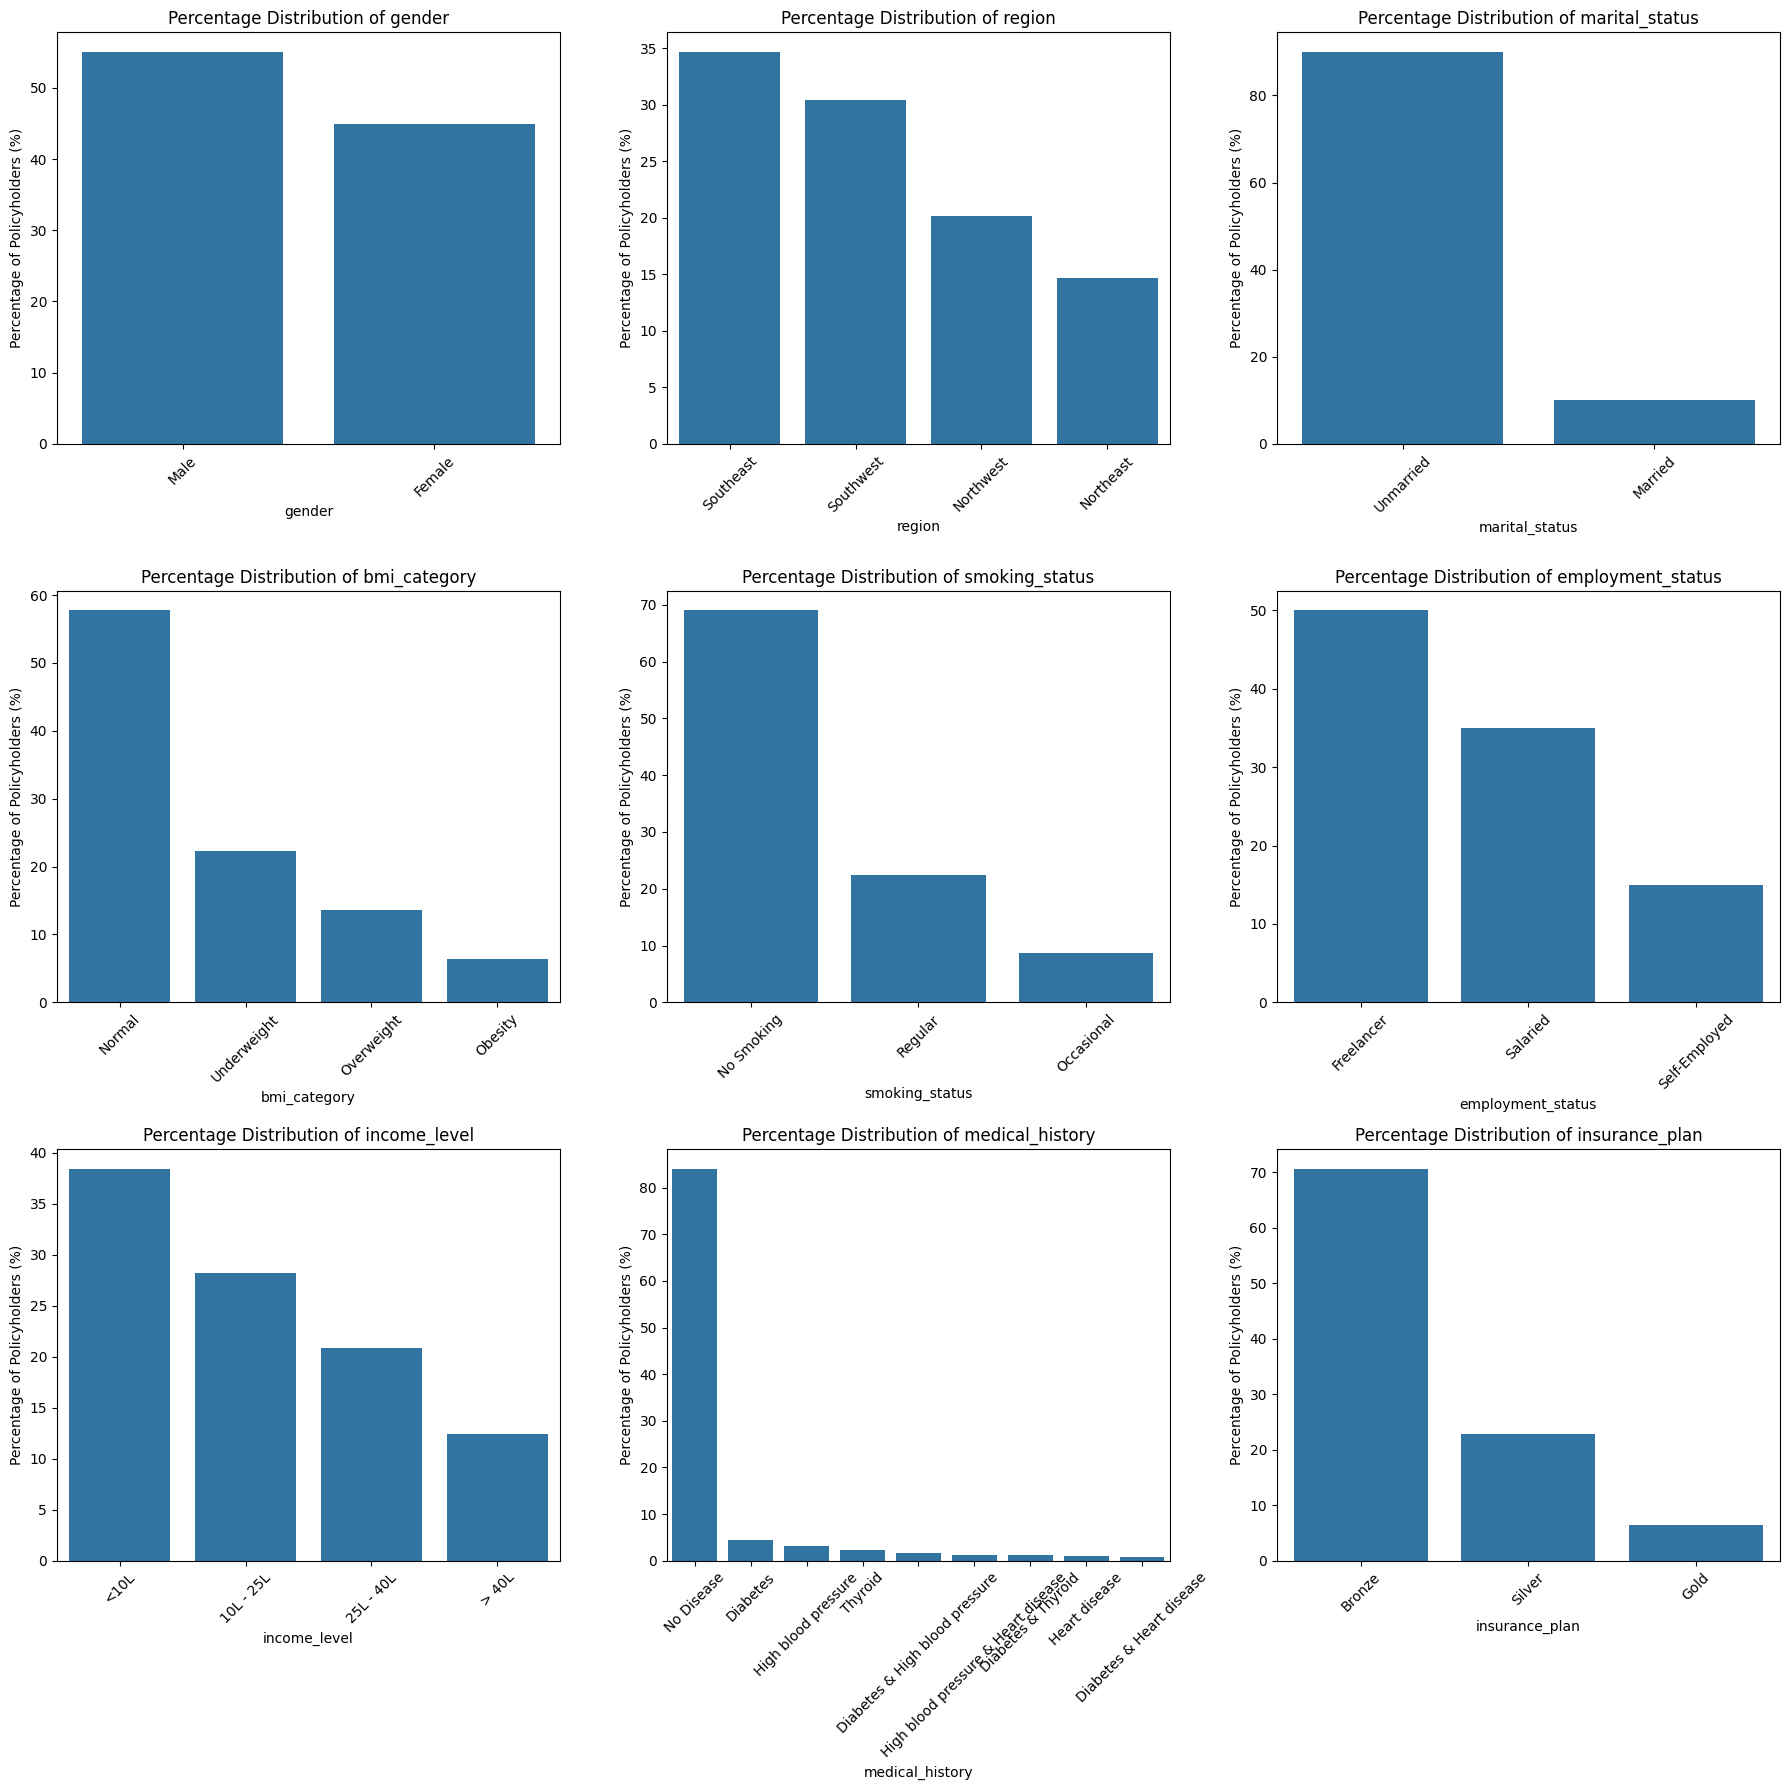

In [169]:
fig, axes = plt.subplots(3, 3, figsize=(18, 18))  
axes = axes.flatten()  # Flatten the 2D array of axes into 1D for easier iteration

for ax, column in zip(axes, categorical_cols):
    # Calculate the percentage distribution of each category
    category_counts = df2[column].value_counts(normalize=True) * 100  # normalize=True gives the relative frequencies
    
    # Plotting the distribution using barplot
    sns.barplot(x=category_counts.index, y=category_counts.values, ax=ax)
    ax.set_title(f'Percentage Distribution of {column}')
    ax.set_ylabel('Percentage of Policyholders (%)')
    ax.set_xlabel(column)  # Set xlabel to the column name for clarity
    ax.tick_params(axis='x', rotation=45)

plt.tight_layout()  
plt.show()

### Bivariate Analysis: Categorical columns

insurance_plan  Bronze  Gold  Silver
income_level                        
10L - 25L         4508   326     828
25L - 40L         3382   209     608
<10L              6172   404    1145
> 40L              115   366    2023


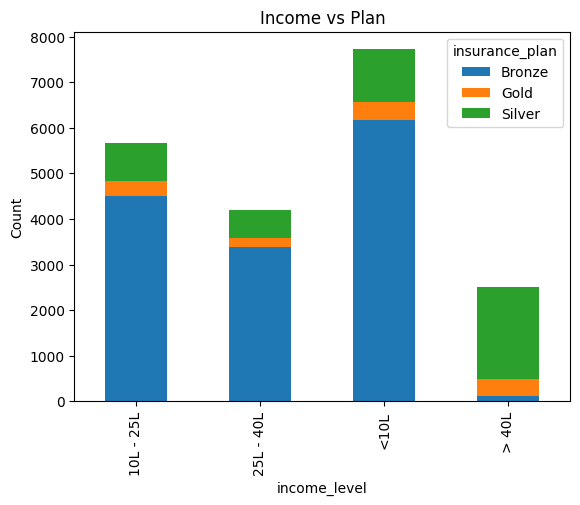

In [171]:
# Cross-tabulation of gender and smoking status
crosstab = pd.crosstab(df2.income_level, df2.insurance_plan)
print(crosstab)
crosstab.plot(kind = 'bar', stacked = True)
plt.title('Income vs Plan')
plt.ylabel('Count')
plt.show()

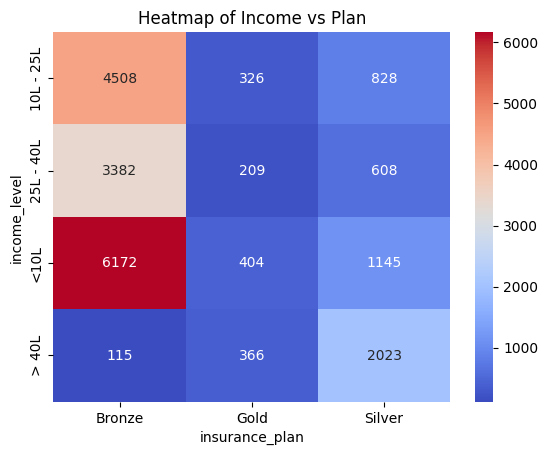

In [172]:
sns.heatmap(crosstab, annot=True, cmap='coolwarm',fmt="d")
plt.title('Heatmap of Income vs Plan')
plt.show()

### 3. Feature Engineering

In [174]:
df2.head()

,age,gender,region,marital_status,number_of_dependants,bmi_category,smoking_status,employment_status,income_level,income_lakhs,medical_history,insurance_plan,annual_premium_amount
0,18,Male,Northeast,Unmarried,0,Overweight,Regular,Self-Employed,> 40L,99,High blood pressure,Silver,13365
1,22,Female,Northwest,Unmarried,0,Underweight,No Smoking,Freelancer,<10L,3,No Disease,Silver,11050
2,21,Female,Southeast,Unmarried,0,Normal,Regular,Salaried,> 40L,97,No Disease,Silver,11857
3,25,Male,Southeast,Unmarried,0,Normal,No Smoking,Freelancer,10L - 25L,15,No Disease,Bronze,5684
4,20,Male,Southeast,Unmarried,2,Overweight,No Smoking,Freelancer,10L - 25L,14,No Disease,Bronze,5712


In [175]:
df2.medical_history.unique()

array(['High blood pressure', 'No Disease',
       'Diabetes & High blood pressure', 'Diabetes & Heart disease',
       'Diabetes', 'Diabetes & Thyroid', 'Heart disease', 'Thyroid',
       'High blood pressure & Heart disease'], dtype=object)

In [176]:
## here we can calculate and assign some kind of risk score becaus ml models can't process this text values.
## more diseases -> more premium

In [177]:
## Define the risk scores for each condition.
## Logic used here is just an example. In real world, stakeholders decide what to do in situations like these.

risk_scores = {
    "diabetes": 6,
    "heart disease": 8,
    "high blood pressure":6,
    "thyroid": 5,
    "no disease": 0,
    "none":0
}

df2[['disease1', 'disease2']] = df2['medical_history'].str.split(" & ", expand=True).apply(lambda x: x.str.lower())
df2['disease1'].fillna('none', inplace=True)
df2['disease2'].fillna('none', inplace=True)
df2['total_risk_score'] = 0

for disease in ['disease1', 'disease2']:
    df2['total_risk_score'] += df2[disease].map(risk_scores)

# Normalize the risk score to a range of 0 to 1
max_score = df2['total_risk_score'].max()
min_score = df2['total_risk_score'].min()
df2['normalized_risk_score'] = (df2['total_risk_score'] - min_score) / (max_score - min_score)
df2.sample(20)

C:\Users\Asus\AppData\Local\Temp\ipykernel_10836\3519769614.py:14: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df2['disease1'].fillna('none', inplace=True)
C:\Users\Asus\AppData\Local\Temp\ipykernel_10836\3519769614.py:15: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example

,age,gender,region,marital_status,number_of_dependants,bmi_category,smoking_status,employment_status,income_level,income_lakhs,medical_history,insurance_plan,annual_premium_amount,disease1,disease2,total_risk_score,normalized_risk_score
13881,24,Male,Southwest,Unmarried,0,Normal,Regular,Freelancer,25L - 40L,40,No Disease,Silver,12062,no disease,none,0,0.000000
1496,20,Male,Southeast,Unmarried,0,Normal,No Smoking,Self-Employed,<10L,9,No Disease,Silver,8275,no disease,none,0,0.000000
7605,25,Male,Southwest,Unmarried,0,Overweight,No Smoking,Salaried,<10L,2,No Disease,Bronze,5004,no disease,none,0,0.000000
13058,18,Female,Northeast,Unmarried,1,Normal,No Smoking,Freelancer,<10L,7,Diabetes,Bronze,4094,diabetes,none,6,0.428571
12502,24,Female,Southeast,Married,3,Obesity,No Smoking,Salaried,<10L,9,No Disease,Bronze,6850,no disease,none,0,0.000000
1825,20,Female,Southeast,Unmarried,0,Normal,No Smoking,Salaried,10L - 25L,13,Diabetes,Gold,13437,diabetes,none,6,0.428571
2136,22,Male,Northwest,Unmarried,0,Overweight,No Smoking,Freelancer,<10L,3,High blood pressure,Bronze,7718,high blood pressure,none,6,0.428571
9161,21,Male,Southeast,Unmarried,1,Overweight,No Smoking,Freelancer,> 40L,40,No Disease,Silver,10526,no disease,none,0,0.000000
4940,24,Male,Southeast,Unmarried,1,Normal,Regular,Salaried,<10L,6,No Disease,Bronze,6125,no disease,none,0,0.000000
8141,25,Female,Southeast,Unmarried,0,Overweight,No Smoking,Freelancer,25L - 40L,35,No Disease,Bronze,6357,no disease,none,0,0.000000


### Label encoding text columns

In [179]:
df2.insurance_plan.unique

<bound method Series.unique of 0        Silver
1        Silver
2        Silver
3        Bronze
4        Bronze
          ...  
20091      Gold
20092      Gold
20093    Bronze
20094    Bronze
20095    Bronze
Name: insurance_plan, Length: 20086, dtype: object>

In [180]:
df2['insurance_plan'] = df2['insurance_plan'].map({'Bronze': 1, 'Silver': 2, 'Gold': 3})

In [181]:
df2.income_level.unique()

array(['> 40L', '<10L', '10L - 25L', '25L - 40L'], dtype=object)

In [182]:
df2['income_level'] = df2['income_level'].map({'<10L':1, '10L - 25L': 2, '25L - 40L':3, '> 40L':4})

In [183]:
df2.head()

,age,gender,region,marital_status,number_of_dependants,bmi_category,smoking_status,employment_status,income_level,income_lakhs,medical_history,insurance_plan,annual_premium_amount,disease1,disease2,total_risk_score,normalized_risk_score
0,18,Male,Northeast,Unmarried,0,Overweight,Regular,Self-Employed,4,99,High blood pressure,2,13365,high blood pressure,none,6,0.428571
1,22,Female,Northwest,Unmarried,0,Underweight,No Smoking,Freelancer,1,3,No Disease,2,11050,no disease,none,0,0.000000
2,21,Female,Southeast,Unmarried,0,Normal,Regular,Salaried,4,97,No Disease,2,11857,no disease,none,0,0.000000
3,25,Male,Southeast,Unmarried,0,Normal,No Smoking,Freelancer,2,15,No Disease,1,5684,no disease,none,0,0.000000
4,20,Male,Southeast,Unmarried,2,Overweight,No Smoking,Freelancer,2,14,No Disease,1,5712,no disease,none,0,0.000000


### Label encoding text columns

In [185]:
nominal_cols = ['gender', 'region', 'marital_status', 'bmi_category', 'smoking_status', 'employment_status']
df3 = pd.get_dummies(df2, columns=nominal_cols, drop_first=True, dtype=int)
df3.head(3)

,age,number_of_dependants,income_level,income_lakhs,medical_history,insurance_plan,annual_premium_amount,disease1,disease2,total_risk_score,...,region_Southeast,region_Southwest,marital_status_Unmarried,bmi_category_Obesity,bmi_category_Overweight,bmi_category_Underweight,smoking_status_Occasional,smoking_status_Regular,employment_status_Salaried,employment_status_Self-Employed
0,18,0,4,99,High blood pressure,2,13365,high blood pressure,none,6,...,0,0,1,0,1,0,0,1,0,1
1,22,0,1,3,No Disease,2,11050,no disease,none,0,...,0,0,1,0,0,1,0,0,0,0
2,21,0,4,97,No Disease,2,11857,no disease,none,0,...,1,0,1,0,0,0,0,1,1,0


## 3. Feature Selection

In [187]:
df3.info()

<class 'pandas.core.frame.DataFrame'>
Index: 20086 entries, 0 to 20095
Data columns (total 23 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   age                              20086 non-null  int64  
 1   number_of_dependants             20086 non-null  int64  
 2   income_level                     20086 non-null  int64  
 3   income_lakhs                     20086 non-null  int64  
 4   medical_history                  20086 non-null  object 
 5   insurance_plan                   20086 non-null  int64  
 6   annual_premium_amount            20086 non-null  int64  
 7   disease1                         20086 non-null  object 
 8   disease2                         20086 non-null  object 
 9   total_risk_score                 20086 non-null  int64  
 10  normalized_risk_score            20086 non-null  float64
 11  gender_Male                      20086 non-null  int64  
 12  region_Northwest       

In [188]:
df4 = df3.drop(['medical_history','disease1', 'disease2', 'total_risk_score'], axis=1)
df4.head(3)                

,age,number_of_dependants,income_level,income_lakhs,insurance_plan,annual_premium_amount,normalized_risk_score,gender_Male,region_Northwest,region_Southeast,region_Southwest,marital_status_Unmarried,bmi_category_Obesity,bmi_category_Overweight,bmi_category_Underweight,smoking_status_Occasional,smoking_status_Regular,employment_status_Salaried,employment_status_Self-Employed
0,18,0,4,99,2,13365,0.428571,1,0,0,0,1,0,1,0,0,1,0,1
1,22,0,1,3,2,11050,0.000000,0,1,0,0,1,0,0,1,0,0,0,0
2,21,0,4,97,2,11857,0.000000,0,0,1,0,1,0,0,0,0,1,1,0


#### Calculate VIF for Multicolinearity

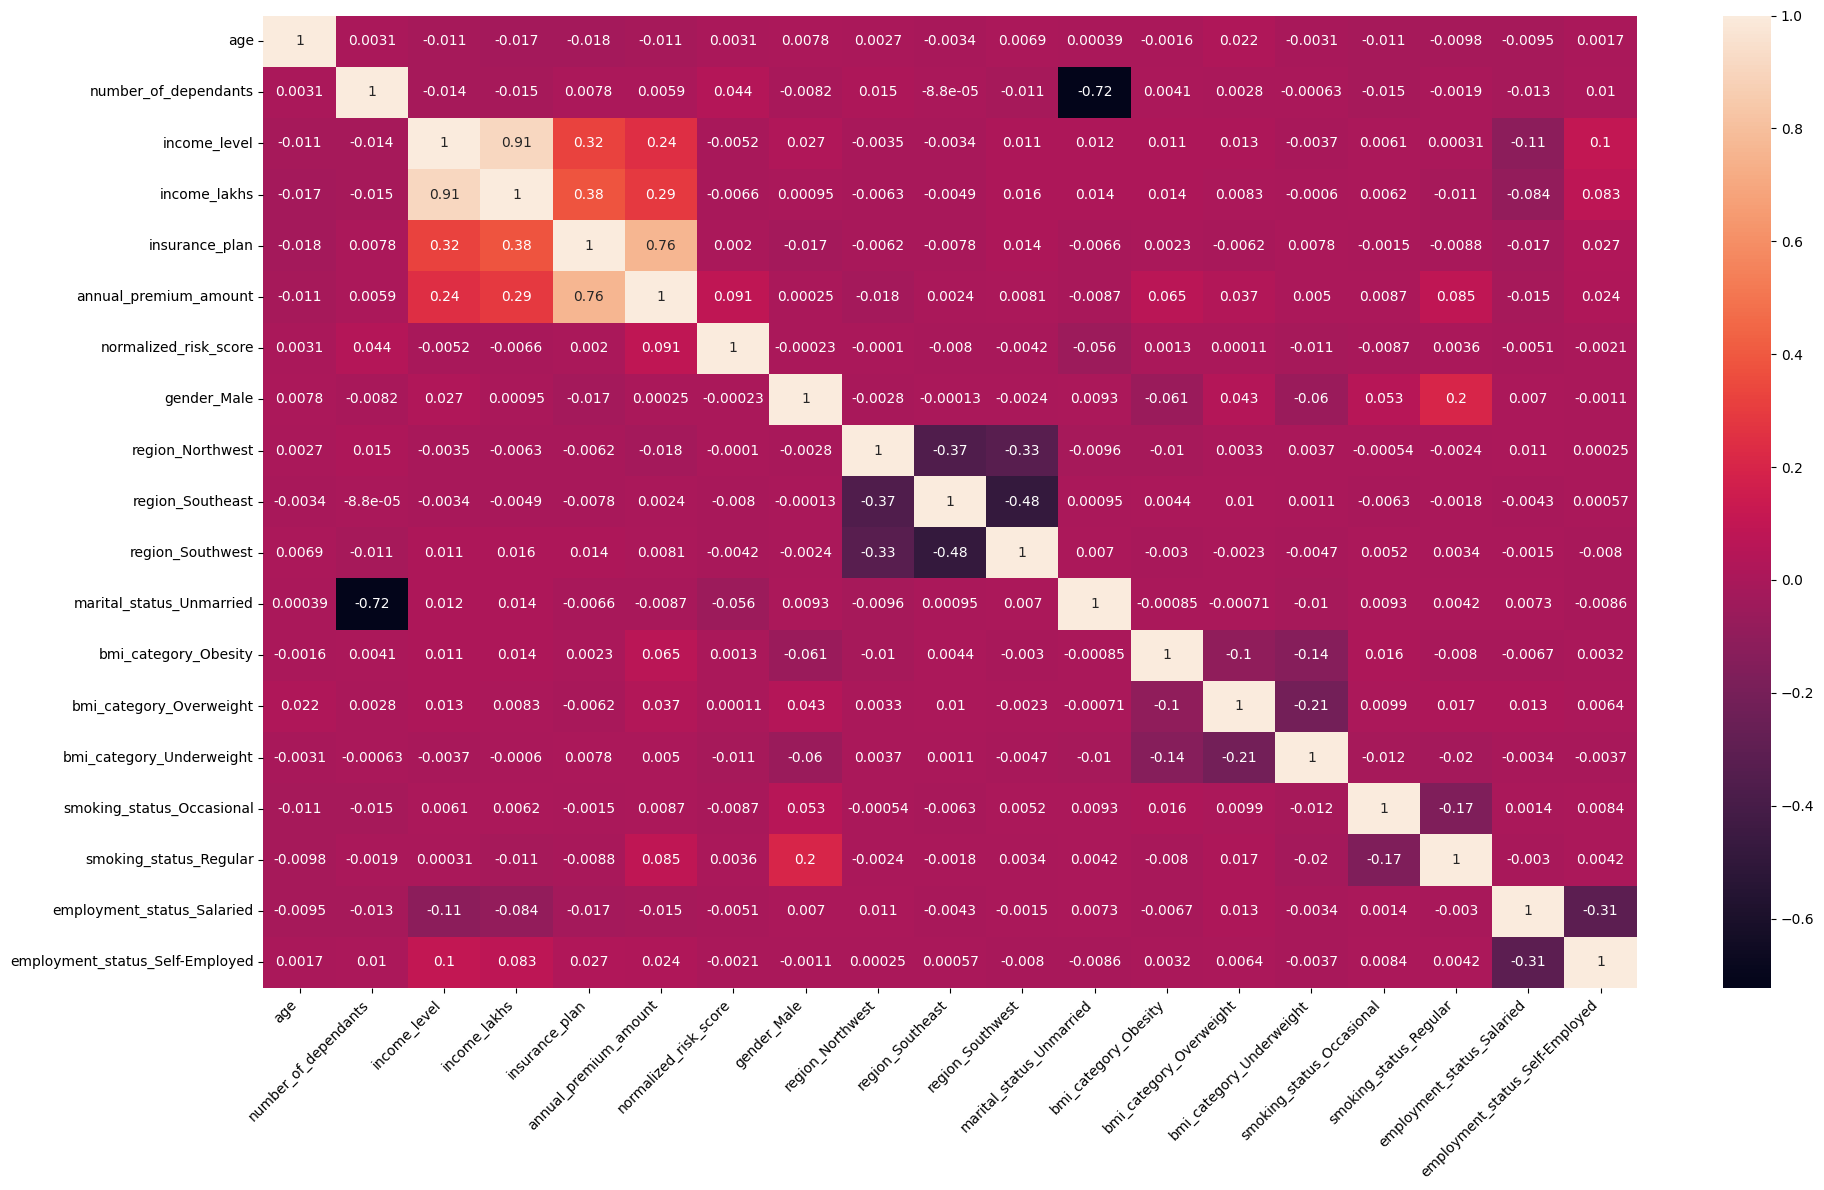

In [190]:
## correlation analysis
cm = df4.corr()

plt.figure(figsize=(20,12))
sns.heatmap(cm, annot=True)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

In [191]:
## feature scaling

X = df4.drop('annual_premium_amount', axis='columns')
y = df4['annual_premium_amount']

from sklearn.preprocessing import MinMaxScaler

cols_to_scale = ['age','number_of_dependants', 'income_level',  'income_lakhs', 'insurance_plan']
scaler = MinMaxScaler()

X[cols_to_scale] = scaler.fit_transform(X[cols_to_scale])
X.describe()

,age,number_of_dependants,income_level,income_lakhs,insurance_plan,normalized_risk_score,gender_Male,region_Northwest,region_Southeast,region_Southwest,marital_status_Unmarried,bmi_category_Obesity,bmi_category_Overweight,bmi_category_Underweight,smoking_status_Occasional,smoking_status_Regular,employment_status_Salaried,employment_status_Self-Employed
count,20086.000000,20086.000000,20086.000000,20086.000000,20086.000000,20086.000000,20086.000000,20086.000000,20086.000000,20086.000000,20086.000000,20086.000000,20086.000000,20086.000000,20086.000000,20086.000000,20086.000000,20086.000000
mean,0.499211,0.240914,0.357994,0.216064,0.179578,0.092076,0.550383,0.201284,0.346958,0.304590,0.899881,0.063527,0.136513,0.222493,0.086379,0.223589,0.350045,0.149955
std,0.327750,0.312413,0.347481,0.219516,0.300051,0.230016,0.497467,0.400970,0.476014,0.460245,0.300167,0.243914,0.343341,0.415931,0.280929,0.416660,0.476996,0.357036
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.142857,0.000000,0.000000,0.050505,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.571429,0.000000,0.333333,0.151515,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.714286,0.333333,0.666667,0.303030,0.500000,0.000000,1.000000,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [192]:
## calculating VIF
from statsmodels.stats.outliers_influence import variance_inflation_factor

def calculate_vif(data):
    vif_df = pd.DataFrame()
    vif_df['Column'] = data.columns
    vif_df['VIF'] = [variance_inflation_factor(data.values,i) for i in range(data.shape[1])]
    return vif_df

In [193]:
calculate_vif(X)

,Column,VIF
0,age,3.142881
1,number_of_dependants,1.860761
2,income_level,11.928707
3,income_lakhs,11.874242
4,insurance_plan,1.592892
5,normalized_risk_score,1.154223
6,gender_Male,2.310023
7,region_Northwest,2.147701
8,region_Southeast,2.970188
9,region_Southwest,2.730503


In [194]:
calculate_vif(X.drop('income_level', axis="columns")) ## vif value after droppinh the column with highest vif value looks perfectly fine.

,Column,VIF
0,age,3.141534
1,number_of_dependants,1.858110
2,income_lakhs,2.291873
3,insurance_plan,1.587794
4,normalized_risk_score,1.154174
5,gender_Male,2.299848
6,region_Northwest,2.146767
7,region_Southeast,2.968993
8,region_Southwest,2.729813
9,marital_status_Unmarried,7.299818


In [195]:
# we will drop income_lakhs due to high VIF value
X_reduced = X.drop('income_level', axis="columns")

## 4. Model training    

In [197]:
X_train, X_test, y_train, y_test = train_test_split(X_reduced, y, test_size=0.30, random_state=10)

# shape of the X_train, X_test, y_train, y_test features
print("x train: ",X_train.shape)
print("x test: ",X_test.shape)
print("y train: ",y_train.shape)
print("y test: ",y_test.shape)

x train:  (14060, 17)
x test:  (6026, 17)
y train:  (14060,)
y test:  (6026,)


#### i. Linear Regression Model

In [199]:
model_lr = LinearRegression()
model_lr.fit(X_train, y_train)
test_score = model_lr.score(X_test, y_test)
train_score = model_lr.score(X_train, y_train)
train_score, test_score

(0.6020471274164894, 0.6047589163893645)

In [200]:
## Only 60 percent accuracy below age 25 using lr

In [201]:
y_pred = model_lr.predict(X_test)

mse_lr = mean_squared_error(y_test, y_pred)
rmse_lr = np.sqrt(mse_lr)
print("Linear Regression ==> MSE: ", mse_lr, "RMSE: ", rmse_lr)

Linear Regression ==> MSE:  3005669.8791236714 RMSE:  1733.6867880686152


In [202]:
X_test.shape

(6026, 17)

In [203]:
X_test.head(1)

,age,number_of_dependants,income_lakhs,insurance_plan,normalized_risk_score,gender_Male,region_Northwest,region_Southeast,region_Southwest,marital_status_Unmarried,bmi_category_Obesity,bmi_category_Overweight,bmi_category_Underweight,smoking_status_Occasional,smoking_status_Regular,employment_status_Salaried,employment_status_Self-Employed
12774,1.0,0.666667,0.040404,0.0,0.0,1,0,0,1,1,0,0,1,0,0,0,0


In [204]:
np.set_printoptions(suppress=True, precision=6)
model_lr.coef_

array([  55.190515, -145.039643,  -36.066768, 7000.070416, 1111.278786,
          9.825648, -114.27345 ,  -36.466371,  -67.223225,  -58.534342,
        792.95266 ,  435.760406,  169.728916,  244.813937,  619.082947,
        -13.053549,   -4.342722])

In [205]:
feature_importance = model_lr.coef_ ## It tells how much important the features are for the final prediction. In LR, feature importance is simply coefficients.    

# Create a DataFrame for easier handling
coef_df = pd.DataFrame(feature_importance, index=X_train.columns, columns=['Coefficients'])

# Sort the coefficients for better visualization
coef_df = coef_df.sort_values(by='Coefficients', ascending=True)
coef_df

,Coefficients
number_of_dependants,-145.039643
region_Northwest,-114.273450
region_Southwest,-67.223225
marital_status_Unmarried,-58.534342
region_Southeast,-36.466371
income_lakhs,-36.066768
employment_status_Salaried,-13.053549
employment_status_Self-Employed,-4.342722
gender_Male,9.825648
age,55.190515


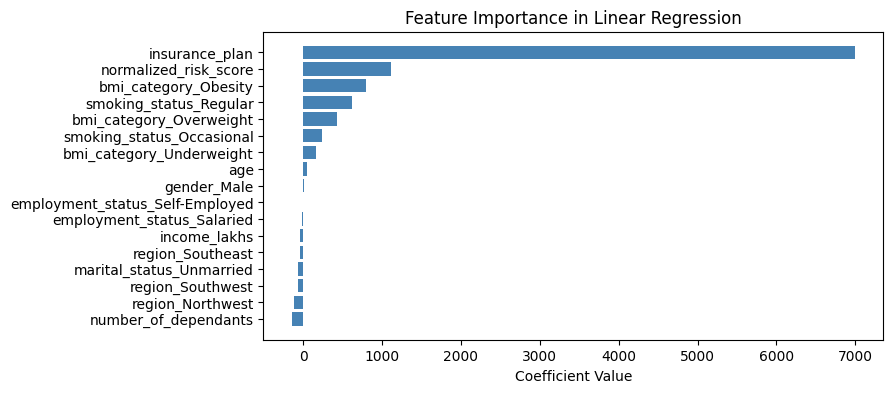

In [206]:
#Plotting
plt.figure(figsize=(8, 4))
plt.barh(coef_df.index, coef_df['Coefficients'], color='steelblue')
plt.xlabel('Coefficient Value')
plt.title('Feature Importance in Linear Regression')
plt.show()

#### ii. Ridge Regression Model

In [208]:
model_rg = Ridge(alpha=1)
model_rg.fit(X_train, y_train)
test_score = model_rg.score(X_test, y_test)
train_score = model_rg.score(X_train, y_train)
train_score, test_score

(0.6020466631305188, 0.6047715291063815)

In [209]:
y_pred = model_rg.predict(X_test)

mse_lr = mean_squared_error(y_test, y_pred)
rmse_lr = np.sqrt(mse_lr)
print("Ridge Regression ==> MSE: ", mse_lr, "RMSE: ", rmse_lr)

Ridge Regression ==> MSE:  3005573.9638324636 RMSE:  1733.6591256162394


#### iii. XGBoost 

In [211]:
from xgboost import XGBRegressor

model_xgb = XGBRegressor(n_estimators=20, max_depth=3)
model_xgb.fit(X_train, y_train)
test_score = model_xgb.score(X_test, y_test)
train_score = model_xgb.score(X_train, y_train)
train_score, test_score

(0.605730414390564, 0.6031962633132935)

In [212]:
y_pred = model_xgb.predict(X_test)

mse_lr = mean_squared_error(y_test, y_pred)
rmse_lr = np.sqrt(mse_lr)
print("XGBoost Regression ==> MSE: ", mse_lr, "RMSE: ", rmse_lr)

XGBoost Regression ==> MSE:  3017553.5814120327 RMSE:  1737.1106992394102


In [213]:
model_xgb = XGBRegressor()
param_grid = {
    'n_estimators': [20, 40, 50],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 4, 5],
}
random_search = RandomizedSearchCV(model_xgb, param_grid, n_iter=10, cv=3, scoring='r2', random_state=42, n_jobs=-1)
random_search.fit(X_train, y_train)
random_search.best_score_

np.float64(0.5997088948885599)

In [214]:
random_search.best_params_

{'n_estimators': 50, 'max_depth': 3, 'learning_rate': 0.1}

In [215]:
##both lr and xgb are giving approx same value so we'll select linear regression 

In [216]:
best_model = model_lr

In [217]:
## This feature importance has less explainability and interpretation then linear regression's. Its not actual coefficient like in LR where we can do direct math
## with the help of coefficients. In tree based model, the explainabilty more complex as compared to linear models.

## 5. Error Analysis

In [219]:
## We can't just rely on r2 score and deploy the model. We need to find the margin of error for each of the sample we are running our prediction.

In [220]:
y_pred = best_model.predict(X_test)

residuals = y_pred - y_test
residuals_pct = (residuals / y_test) * 100

results_df = pd.DataFrame({
    'actual': y_test, 
    'predicted': y_pred, 
    'diff': residuals, 
    'diff_pct': residuals_pct
})
results_df.head()

,actual,predicted,diff,diff_pct
12774,6238,6625.420564,387.420564,6.210653
14758,9462,7117.148903,-2344.851097,-24.781770
13205,5152,7052.316369,1900.316369,36.885023
14278,6988,7924.504344,936.504344,13.401608
19351,4917,6696.274716,1779.274716,36.186185


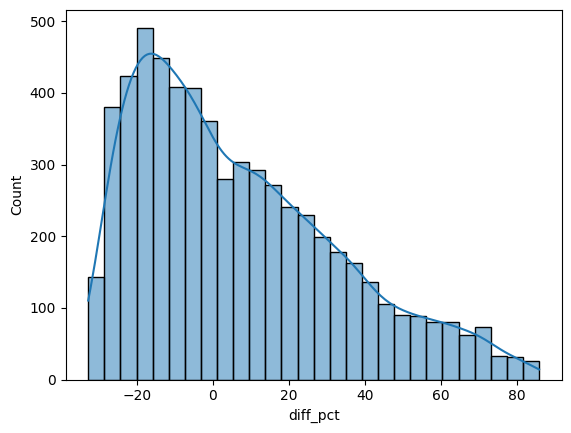

In [221]:
sns.histplot(results_df.diff_pct, kde = True)
plt.show()

In [222]:
## There are many records where we are predicting the premium upto 80 percent higher. Basically wrong output.

In [223]:
extreme_error_threshold = 10  # We can adjust this threshold based on domain knowledge or requirements
extreme_results_df = results_df[np.abs(results_df['diff_pct']) > extreme_error_threshold]
extreme_results_df.head()

,actual,predicted,diff,diff_pct
14758,9462,7117.148903,-2344.851097,-24.781770
13205,5152,7052.316369,1900.316369,36.885023
14278,6988,7924.504344,936.504344,13.401608
19351,4917,6696.274716,1779.274716,36.186185
10622,8947,7325.713340,-1621.286660,-18.121009


In [224]:
extreme_results_df.shape

(4404, 4)

In [225]:
results_df.shape

(6026, 4)

In [226]:
extreme_errors_pct = extreme_results_df.shape[0]*100/X_test.shape[0]
extreme_errors_pct

73.08330567540658

In [227]:
## Around 73 percert error ratio

In [228]:
extreme_results_df[abs(extreme_results_df.diff_pct)>50].sort_values("diff_pct",ascending=False).shape ## more than 50 percent error margin in extreme_df

(512, 4)

In [229]:
extreme_results_df[abs(extreme_results_df.diff_pct)>50].sort_values("diff_pct",ascending=False)

,actual,predicted,diff,diff_pct
10288,3623,6730.355627,3107.355627,85.767475
16580,3538,6566.644257,3028.644257,85.603286
3652,3536,6560.929382,3024.929382,85.546645
17084,3562,6608.314334,3046.314334,85.522581
18629,3616,6684.432249,3068.432249,84.857087
...,...,...,...,...
1597,4653,6988.954171,2335.954171,50.203184
12185,4440,6666.968404,2226.968404,50.156946
15966,4709,7070.742860,2361.742860,50.153809
4086,4592,6890.471576,2298.471576,50.053824


In [230]:
##There will be about 549 customers whom we will overcharge or underchage by more than 50%

In [231]:
extreme_results_df.index

Index([14758, 13205, 14278, 19351, 10622, 14799, 16348,  5573,  5634, 14882,
       ...
       10266,  5484,  8988,  9658,  1365,   399, 17652,  5807, 10298, 13316],
      dtype='int64', length=4404)

In [232]:
extreme_errors_df = X_test.loc[extreme_results_df.index]
extreme_errors_df.head()

,age,number_of_dependants,income_lakhs,insurance_plan,normalized_risk_score,gender_Male,region_Northwest,region_Southeast,region_Southwest,marital_status_Unmarried,bmi_category_Obesity,bmi_category_Overweight,bmi_category_Underweight,smoking_status_Occasional,smoking_status_Regular,employment_status_Salaried,employment_status_Self-Employed
14758,0.285714,0.000000,0.060606,0.0,0.000000,0,0,0,1,1,0,0,0,0,1,0,1
13205,0.714286,0.333333,0.141414,0.0,0.000000,1,1,0,0,1,0,0,0,0,1,0,1
14278,0.714286,0.333333,0.222222,0.0,0.000000,1,0,1,0,1,1,0,0,0,1,0,0
19351,0.571429,0.000000,0.101010,0.0,0.000000,1,0,0,1,1,0,0,1,0,0,0,0
10622,0.428571,0.333333,0.050505,0.0,0.357143,0,0,1,0,1,0,1,0,0,0,0,0


In [233]:
## these are the actual rows for which the model is giving wrong info

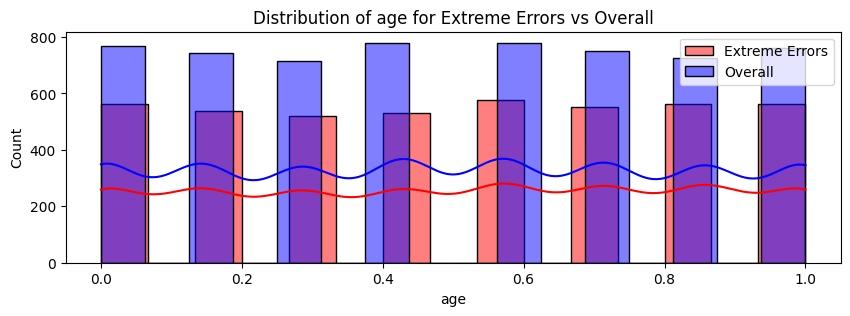

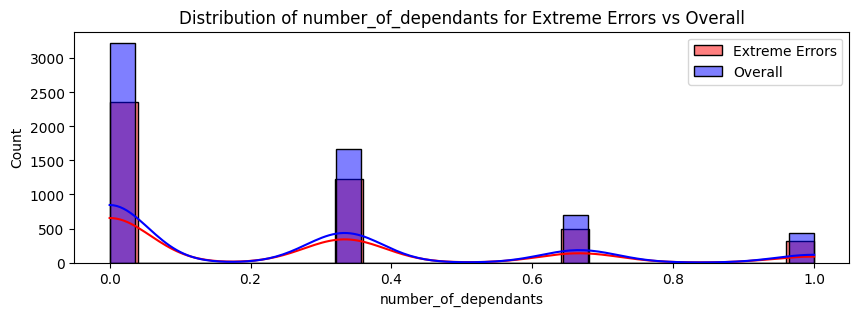

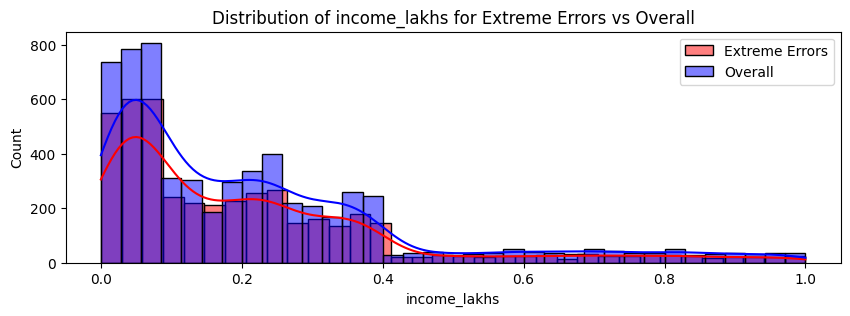

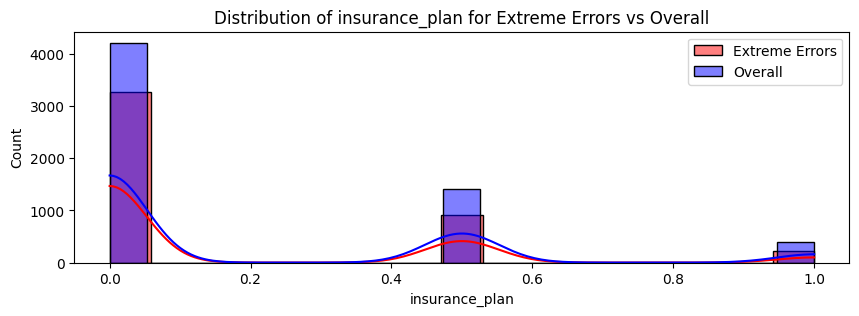

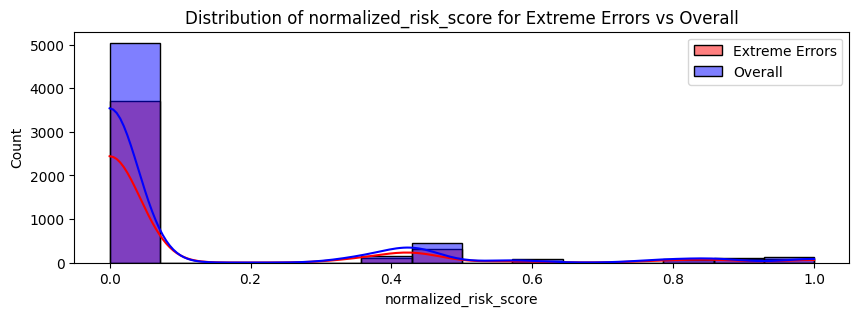

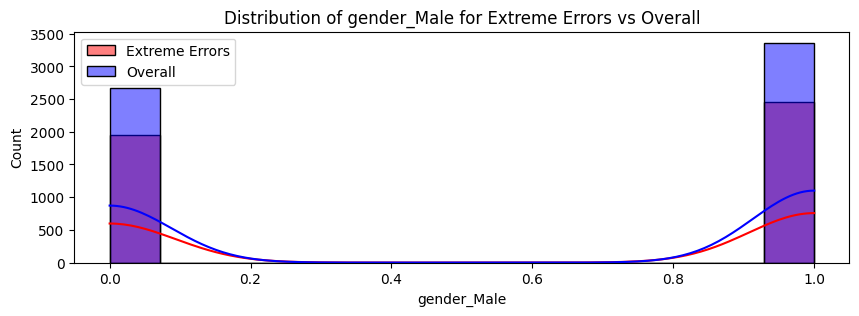

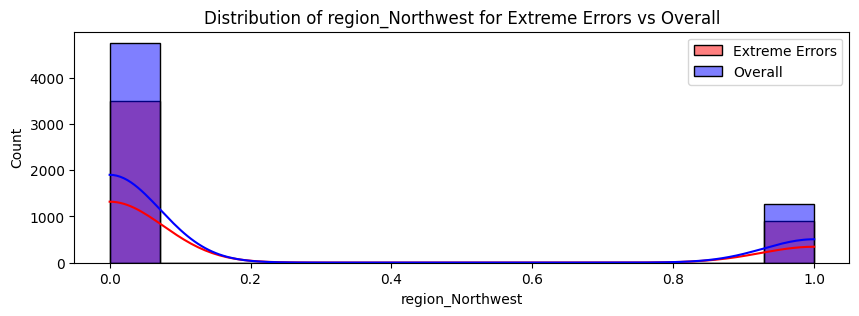

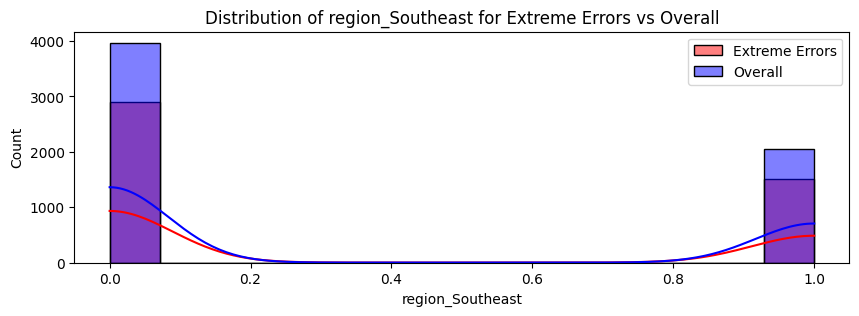

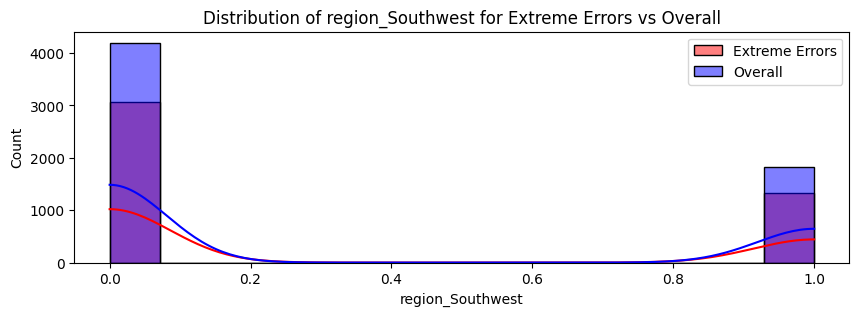

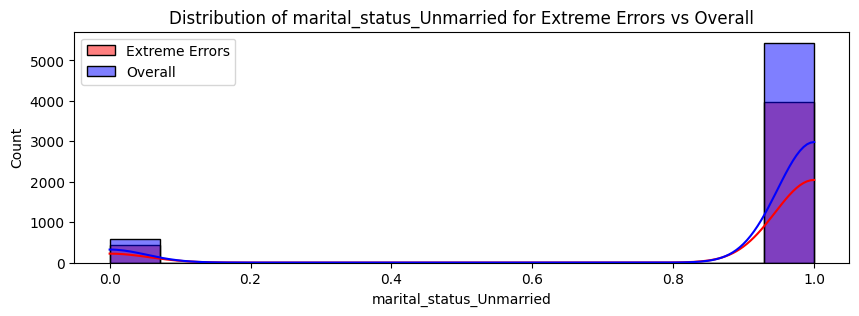

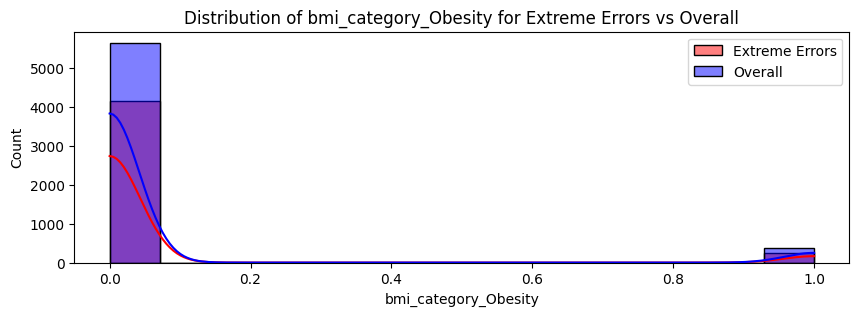

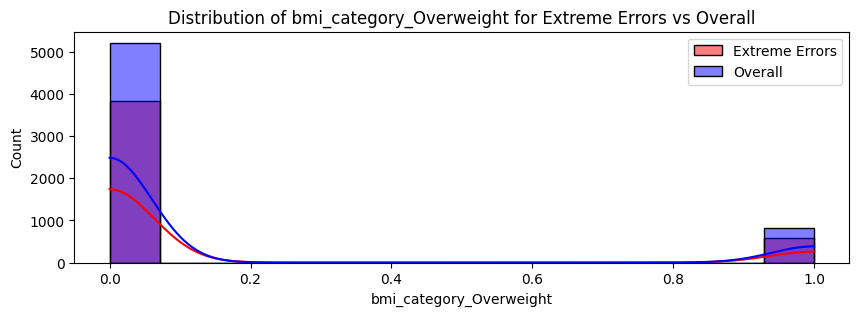

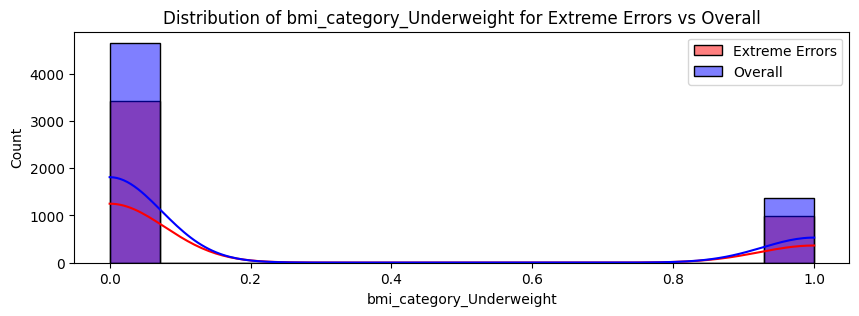

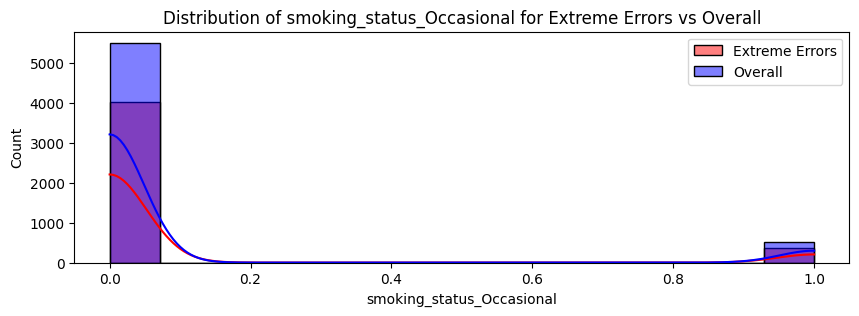

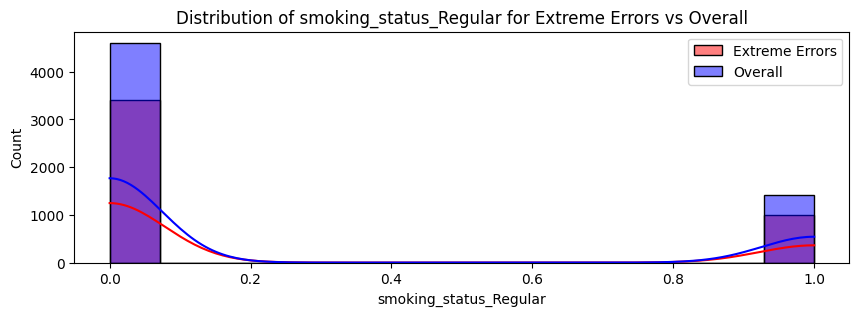

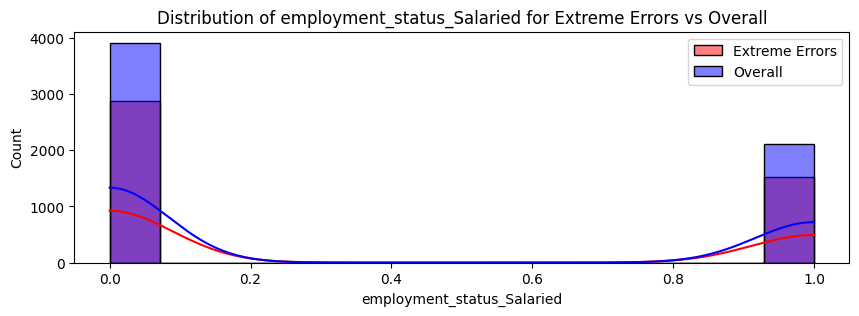

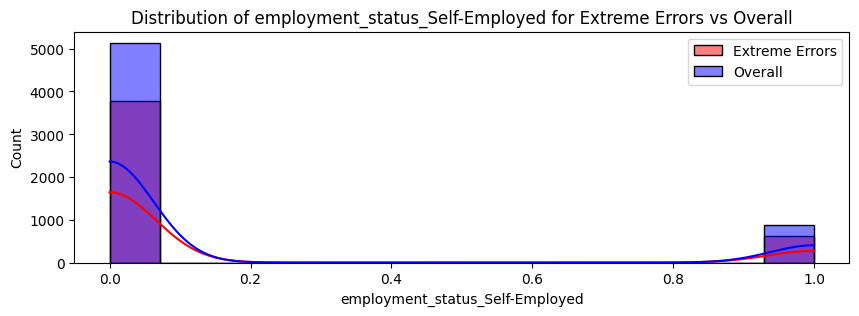

In [234]:
for feature in X_test.columns:
    plt.figure(figsize=(10, 3))
    sns.histplot(extreme_errors_df[feature], color='red', label='Extreme Errors', kde=True)
    sns.histplot(X_test[feature], color='blue', label='Overall', alpha=0.5, kde=True)
    plt.legend()
    plt.title(f'Distribution of {feature} for Extreme Errors vs Overall')
    plt.show()